# Desafio 2.2.

Selecione um sku (produto) e realize uma previsão da demanda do mesmo nos próximos 4 intervalos de tempo de sua escolha (dia, semana, mês, etc) 

métricas: rmse, mape;

dados: time_series_data.xlsx;

#### Bibliotecas que vamos precisar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [2]:
db = pd.read_excel('time_series_data.xlsx')

Antes de começar com o modelo vamos a entender as características da database<br>
aplicaremos os mesmos passos do exercicio anterior

In [3]:
db.sample(4)

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao
4398,A8,45,UN,7.70,20201208
4061,B1,45,UN,8.26,20201210
681,B1,90,UN,8.96,20210726
3232,B2,24,UN,10.68,20210519


In [4]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4460 entries, 0 to 4459
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   produto_descricao                       4460 non-null   object 
 1   produto_quantidade                      4460 non-null   int64  
 2   produto_unidade_comercial               4460 non-null   object 
 3   produto_valor_unitario_comercializacao  4460 non-null   float64
 4   nota_data_emissao                       4460 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 174.3+ KB


In [5]:
db.isna().sum().sum()

0

In [6]:
db.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3827 entries, 0 to 4459
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   produto_descricao                       3827 non-null   object 
 1   produto_quantidade                      3827 non-null   int64  
 2   produto_unidade_comercial               3827 non-null   object 
 3   produto_valor_unitario_comercializacao  3827 non-null   float64
 4   nota_data_emissao                       3827 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 179.4+ KB


In [7]:
db.drop_duplicates(inplace=True)

In [8]:
# Como o valor unitario pode mudar muito de produto para produto, vamos a trabalhar com o produto logo, para não precisar verificar produto por produto, 
# e começar a ter criterios para detectar os outliers
db.describe()

,produto_quantidade,produto_valor_unitario_comercializacao,nota_data_emissao
count,3827.000000,3827.000000,3.827000e+03
mean,476.367390,20.788023,2.020877e+07
std,2190.875014,47.373791,3.705650e+03
min,0.000000,0.620000,2.020100e+07
25%,45.000000,8.260000,2.021013e+07
50%,90.000000,11.420000,2.021043e+07
75%,240.000000,27.200000,2.021072e+07
max,42000.000000,1812.390400,2.021093e+07


In [9]:
# Vamos selecionar o produto B0 ja que é o que tem maior numero de registros, logo é quem melhor pode treinar nosso modelo
db.produto_descricao.value_counts()

B0    850
B3    746
B2    667
A8    581
B1    437
B4    278
A9    128
A0     31
D0     30
B6     15
A7     14
A5      8
B7      6
C5      4
A6      4
C0      3
C1      3
B8      2
B5      2
C2      2
C3      2
C7      2
C9      2
D1      2
A1      1
B9      1
A3      1
C4      1
A4      1
C6      1
C8      1
A2      1
Name: produto_descricao, dtype: int64

In [10]:
db2 = db[db['produto_descricao']=='B0']

In [11]:
db2.describe()

,produto_quantidade,produto_valor_unitario_comercializacao,nota_data_emissao
count,850.000000,850.000000,8.500000e+02
mean,709.104706,28.303924,2.020855e+07
std,2244.179291,7.578582,3.868455e+03
min,1.000000,0.620000,2.020100e+07
25%,60.000000,29.090000,2.021012e+07
50%,240.000000,29.500000,2.021042e+07
75%,600.000000,32.020000,2.021072e+07
max,42000.000000,32.470000,2.021093e+07


In [12]:
# Bem como podemos ver no .describe(), como aqui, existem valores muito baixos para o produto, é dificil acreditar que o produto possa variar de 32 a 0.8
db2.produto_valor_unitario_comercializacao.value_counts()

32.0200    180
29.0900    166
32.4700    149
29.5000    124
29.9400     67
27.2000     60
0.8800      18
32.2400     10
3.6500       9
0.6200       9
29.2900      9
25.6300      8
28.0400      6
0.9700       6
28.2100      6
25.4800      3
3.6000       3
3.2500       2
1.1300       2
0.8000       2
1.4500       2
4.6477       2
5.3100       1
3.2000       1
6.3000       1
3.3600       1
4.7100       1
5.8900       1
4.5800       1
Name: produto_valor_unitario_comercializacao, dtype: int64

In [13]:
#pd.set_option('display.max_rows',None)
pd.reset_option('display.max_rows')

In [14]:
db2.sort_values(by='produto_valor_unitario_comercializacao',ascending=True)

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao
977,B0,1,UN,0.62,20210713
979,B0,2,UN,0.62,20210602
980,B0,2,UN,0.62,20210713
982,B0,3,UN,0.62,20210604
983,B0,3,UN,0.62,20210713
...,...,...,...,...,...
2250,B0,60,UN,32.47,20210513
2239,B0,300,UN,32.47,20210926
2226,B0,60,UN,32.47,20210921
2254,B0,180,UN,32.47,20210521


In [15]:
# Como vimos, o a partir de 25, a oscilação do valor unitario da um pulo significativo. Até antes disso, a variação estava em um range de 25 e 32 aproximadamente
# Então ficaremos com os registros cujo valor unitario é acima de 25
db3 = db2[db2['produto_valor_unitario_comercializacao'] >25]

In [16]:
# Verifiquemos o mesmo, para a quantidade
db3.sort_values(by='produto_quantidade',ascending=True)

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao
1345,B0,1,UN,32.02,20210830
52,B0,2,UN,32.02,20210610
412,B0,2,UN,32.47,20210611
3491,B0,2,UN,29.09,20201110
413,B0,2,UN,32.47,20210908
...,...,...,...,...,...
3708,B0,12000,UN,29.09,20210114
3709,B0,13260,UN,29.09,20201111
251,B0,13491,UN,29.29,20210318
3443,B0,26529,UN,29.29,20210120


In [17]:
# No caso da quantidade parece muito mais acreditavel a quantidade de compras, o unico problema é o registro de 42000 unidades vendidas, se bem pode acontecer, não deixa de ser um outlier
# Vamos a eliminar este registro, apenas para não afetar demais as estatísticas e os modelos de treinamento

db4 = db3[db3['produto_quantidade'] < 42000] # Utilizarei esta forma de escrever puramente para caso seja necessário diminuir mais os outliers, e ir testando.

Antes de começar, vamos a modificar a coluna nota_data_emissao, para que seja nossa coluna de date

In [18]:
db4.sample(3)

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao
2324,B0,1200,UN,29.94,20210522
4259,B0,12,UN,29.09,20201212
2884,B0,1020,UN,32.47,20210609


In [19]:
db4.dtypes

produto_descricao                          object
produto_quantidade                          int64
produto_unidade_comercial                  object
produto_valor_unitario_comercializacao    float64
nota_data_emissao                           int64
dtype: object

In [20]:
db4['nota_data_emissao'] = db4['nota_data_emissao'].astype(str)

C:\Users\Ale\AppData\Local\Temp\ipykernel_10100\447955264.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db4['nota_data_emissao'] = db4['nota_data_emissao'].astype(str)


In [21]:
db4['nota_data_emissao'] = pd.to_datetime(db4['nota_data_emissao'])

C:\Users\Ale\AppData\Local\Temp\ipykernel_10100\1664531204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db4['nota_data_emissao'] = pd.to_datetime(db4['nota_data_emissao'])


Bom, agora ja que temos o dataset que vamos a utilizar, vamos a verificar como ele está composto

In [22]:
db4.dtypes

produto_descricao                                 object
produto_quantidade                                 int64
produto_unidade_comercial                         object
produto_valor_unitario_comercializacao           float64
nota_data_emissao                         datetime64[ns]
dtype: object

In [23]:
## Vamos a gerar novos features para que possam ajudar a prever o forecasting

db4['Year'] = db4['nota_data_emissao'].dt.year;
db4['Month'] = db4['nota_data_emissao'].dt.month;
db4['Day'] = db4['nota_data_emissao'].dt.day;
db4['Day_of_week'] = db4['nota_data_emissao'].dt.day_of_week;
db4['Day_of_year'] = db4['nota_data_emissao'].dt.day_of_year;

C:\Users\Ale\AppData\Local\Temp\ipykernel_10100\4256469673.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db4['Year'] = db4['nota_data_emissao'].dt.year;
C:\Users\Ale\AppData\Local\Temp\ipykernel_10100\4256469673.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db4['Month'] = db4['nota_data_emissao'].dt.month;
C:\Users\Ale\AppData\Local\Temp\ipykernel_10100\4256469673.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [24]:
db4.sample(7)

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao,Year,Month,Day,Day_of_week,Day_of_year
2049,B0,240,UN,32.02,2021-05-16,2021,5,16,6,136
862,B0,420,UN,32.02,2021-08-11,2021,8,11,2,223
2306,B0,840,UN,32.24,2021-07-17,2021,7,17,5,198
1382,B0,300,UN,32.47,2021-09-10,2021,9,10,4,253
3575,B0,240,UN,29.09,2020-12-10,2020,12,10,3,345
911,B0,1920,UN,32.02,2021-05-18,2021,5,18,1,138
1849,B0,300,UN,29.94,2021-05-29,2021,5,29,5,149


In [25]:
db4.describe().round(2)

,produto_quantidade,produto_valor_unitario_comercializacao,Year,Month,Day,Day_of_week,Day_of_year
count,787.00,787.00,787.0,787.00,787.00,787.00,787.00
mean,649.01,30.37,2020.8,6.44,17.55,3.10,182.34
std,1571.14,1.78,0.4,3.13,8.50,1.97,95.74
min,1.00,25.48,2020.0,1.00,1.00,0.00,6.00
25%,60.00,29.09,2021.0,3.00,10.00,1.00,83.00
50%,240.00,29.94,2021.0,7.00,18.00,3.00,183.00
75%,600.00,32.02,2021.0,9.00,26.00,5.00,259.00
max,26529.00,32.47,2021.0,12.00,31.00,6.00,364.00


array([[<AxesSubplot:title={'center':'produto_quantidade'}>,
        <AxesSubplot:title={'center':'produto_valor_unitario_comercializacao'}>,
        <AxesSubplot:title={'center':'nota_data_emissao'}>],
       [<AxesSubplot:title={'center':'Year'}>,
        <AxesSubplot:title={'center':'Month'}>,
        <AxesSubplot:title={'center':'Day'}>],
       [<AxesSubplot:title={'center':'Day_of_week'}>,
        <AxesSubplot:title={'center':'Day_of_year'}>, <AxesSubplot:>]],
      dtype=object)

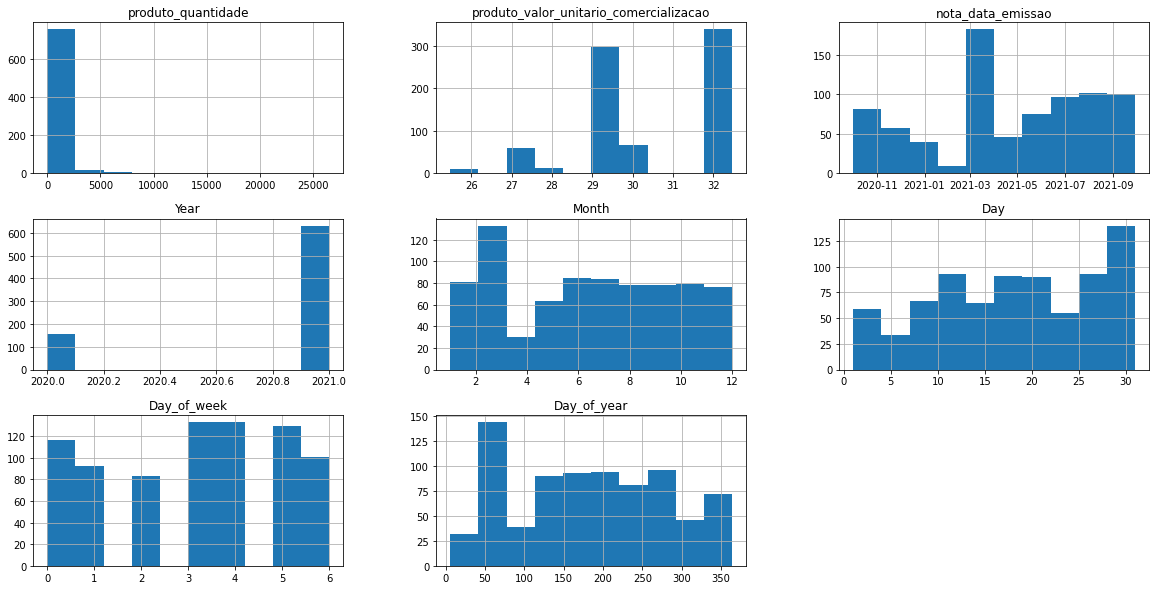

In [26]:
db4.hist(figsize=(20,10))

In [27]:
db4.Month.value_counts()

3     133
6      85
7      84
10     79
8      78
9      78
5      63
12     57
2      49
1      32
4      30
11     19
Name: Month, dtype: int64

In [28]:
db4.Day_of_week.value_counts()

3    133
4    133
5    129
0    116
6    101
1     92
2     83
Name: Day_of_week, dtype: int64

In [29]:
db4.corr()

,produto_quantidade,produto_valor_unitario_comercializacao,Year,Month,Day,Day_of_week,Day_of_year
produto_quantidade,1.000000,-0.098678,0.060811,-0.148316,-0.008261,-0.058034,-0.148253
produto_valor_unitario_comercializacao,-0.098678,1.000000,0.440296,0.126663,0.017110,-0.115705,0.124460
Year,0.060811,0.440296,1.000000,-0.699023,0.008077,-0.091677,-0.700341
Month,-0.148316,0.126663,-0.699023,1.000000,-0.031538,-0.012193,0.995845
Day,-0.008261,0.017110,0.008077,-0.031538,1.000000,0.187547,0.059286
Day_of_week,-0.058034,-0.115705,-0.091677,-0.012193,0.187547,1.000000,0.006704
Day_of_year,-0.148253,0.124460,-0.700341,0.995845,0.059286,0.006704,1.000000


In [30]:
# retiraremos aquilo que não vamos precisar
db4.drop(labels=['produto_unidade_comercial','produto_descricao'],axis=1,inplace=True);

C:\Users\Ale\AppData\Local\Temp\ipykernel_10100\4052009339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db4.drop(labels=['produto_unidade_comercial','produto_descricao'],axis=1,inplace=True);


In [31]:
db5 = db4.copy()

In [32]:
db5.set_index('nota_data_emissao',inplace=True)

In [33]:
db5.dtypes

produto_quantidade                          int64
produto_valor_unitario_comercializacao    float64
Year                                        int64
Month                                       int64
Day                                         int64
Day_of_week                                 int64
Day_of_year                                 int64
dtype: object

<AxesSubplot:xlabel='nota_data_emissao'>

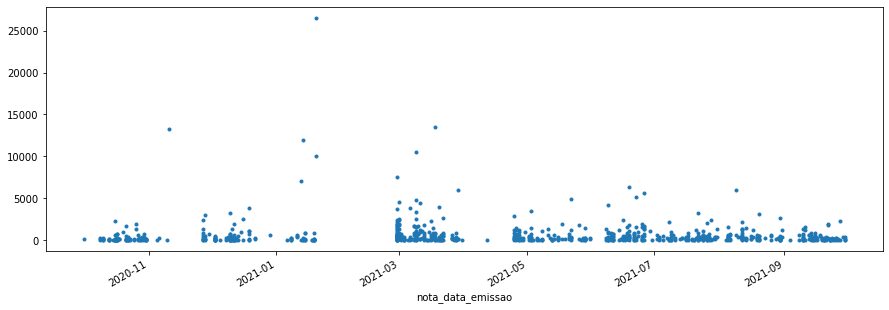

In [34]:
db5['produto_quantidade'].plot(style='.',figsize=(15,5))

In [35]:
db5.sort_values(by='nota_data_emissao')

,produto_quantidade,produto_valor_unitario_comercializacao,Year,Month,Day,Day_of_week,Day_of_year
nota_data_emissao,,,,,,,
2020-10-01,120,29.50,2020,10,1,3,275
2020-10-09,120,29.50,2020,10,9,4,283
2020-10-09,300,27.20,2020,10,9,4,283
2020-10-09,17,29.50,2020,10,9,4,283
2020-10-10,60,29.09,2020,10,10,5,284
...,...,...,...,...,...,...,...
2021-09-29,420,32.47,2021,9,29,2,272
2021-09-30,180,32.02,2021,9,30,3,273
2021-09-30,420,32.02,2021,9,30,3,273


Uma pratica muito comum em forecasting é dividir o dataset de treinamento e test pela data

In [36]:
# Parece uma proporção boa para o treinamento e test, inclusive podería ser ate maior o treinamento, mas vamos a deixar assim por enquanto
train = db5.loc[db5.index < '2021-07-01'] #547 registros
test = db5.loc[db5.index >= '2021-07-01'] #240 registros


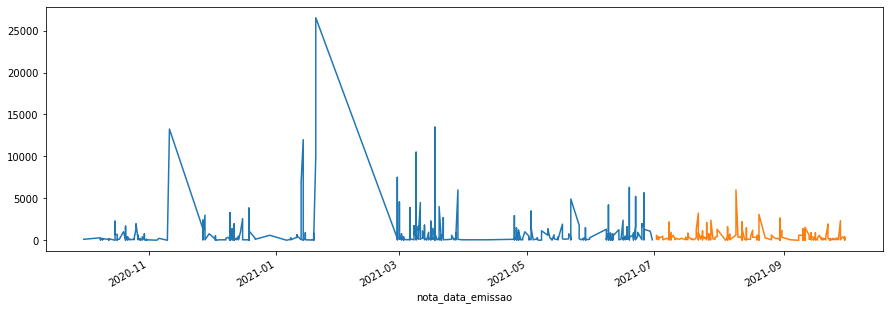

In [37]:
fig, ax = plt.subplots(figsize=(15,5))
train['produto_quantidade'].plot(ax=ax, label="Training Set")
test['produto_quantidade'].plot(ax=ax, label="Test Set")
plt.show()

In [38]:
FEATURES = ['produto_valor_unitario_comercializacao','Month','Day','Day_of_week','Day_of_year']
TARGET = ['produto_quantidade']

In [39]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

#### Primeiro com rmse

In [40]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,learning_rate=0.001)
reg.fit(X_train,y_train,
        eval_set=[(X_train,y_train),(X_test,y_test)],verbose=True,
        eval_metric='rmse')


[0]	validation_0-rmse:1971.62360	validation_1-rmse:771.40178
[1]	validation_0-rmse:1970.74216	validation_1-rmse:771.05125
[2]	validation_0-rmse:1969.86160	validation_1-rmse:770.70158
[3]	validation_0-rmse:1968.98191	validation_1-rmse:770.35275
[4]	validation_0-rmse:1968.09953	validation_1-rmse:769.92107
[5]	validation_0-rmse:1967.21804	validation_1-rmse:769.49065
[6]	validation_0-rmse:1966.33746	validation_1-rmse:769.06150
[7]	validation_0-rmse:1965.45773	validation_1-rmse:768.63361
[8]	validation_0-rmse:1964.57891	validation_1-rmse:768.20698
[9]	validation_0-rmse:1963.70101	validation_1-rmse:767.78161
[10]	validation_0-rmse:1962.82389	validation_1-rmse:767.35749
[11]	validation_0-rmse:1961.94776	validation_1-rmse:766.93463
[12]	validation_0-rmse:1961.07247	validation_1-rmse:766.51303
[13]	validation_0-rmse:1960.19803	validation_1-rmse:766.09270
[14]	validation_0-rmse:1959.32449	validation_1-rmse:765.67361
[15]	validation_0-rmse:1958.45186	validation_1-rmse:765.25577
[16]	validation_0-

c:\Users\Ale\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:1871.55434	validation_1-rmse:725.57251
[121]	validation_0-rmse:1870.77020	validation_1-rmse:725.28136
[122]	validation_0-rmse:1869.98683	validation_1-rmse:724.93218
[123]	validation_0-rmse:1869.20429	validation_1-rmse:724.58420
[124]	validation_0-rmse:1868.42249	validation_1-rmse:724.29643
[125]	validation_0-rmse:1867.64155	validation_1-rmse:723.95077
[126]	validation_0-rmse:1866.86138	validation_1-rmse:723.66523
[127]	validation_0-rmse:1866.08197	validation_1-rmse:723.32192
[128]	validation_0-rmse:1865.30342	validation_1-rmse:722.97979
[129]	validation_0-rmse:1864.52558	validation_1-rmse:722.69758
[130]	validation_0-rmse:1863.74863	validation_1-rmse:722.35778
[131]	validation_0-rmse:1862.97243	validation_1-rmse:722.07781
[132]	validation_0-rmse:1862.19697	validation_1-rmse:721.74034
[133]	validation_0-rmse:1861.42235	validation_1-rmse:721.40401
[134]	validation_0-rmse:1860.64854	validation_1-rmse:721.12736
[135]	validation_0-rmse:1859.87544	validation_1-rmse:72

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [41]:
reg.best_iteration

731

In [42]:
reg.best_score

662.7145726432304

In [43]:
results = reg.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

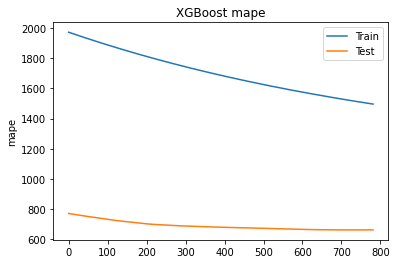

In [44]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('mape')
plt.title('XGBoost mape')
plt.show()

#### Agora com mape

In [45]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,learning_rate=0.001)
reg.fit(X_train,y_train,
        eval_set=[(X_train,y_train),(X_test,y_test)],verbose=True,
        eval_metric='mape')

[0]	validation_0-mape:0.98794	validation_1-mape:0.98400
[1]	validation_0-mape:0.98271	validation_1-mape:0.98020
[2]	validation_0-mape:0.97749	validation_1-mape:0.97640
[3]	validation_0-mape:0.97227	validation_1-mape:0.97261
[4]	validation_0-mape:0.96629	validation_1-mape:0.96488
[5]	validation_0-mape:0.96173	validation_1-mape:0.95715
[6]	validation_0-mape:0.95738	validation_1-mape:0.94987
[7]	validation_0-mape:0.95443	validation_1-mape:0.94478
[8]	validation_0-mape:0.95160	validation_1-mape:0.94013
[9]	validation_0-mape:0.94887	validation_1-mape:0.93649
[10]	validation_0-mape:0.94649	validation_1-mape:0.93333
[11]	validation_0-mape:0.94418	validation_1-mape:0.93017
[12]	validation_0-mape:0.94187	validation_1-mape:0.92774
[13]	validation_0-mape:0.93956	validation_1-mape:0.92538
[14]	validation_0-mape:0.93726	validation_1-mape:0.92319
[15]	validation_0-mape:0.93517	validation_1-mape:0.92146
[16]	validation_0-mape:0.93315	validation_1-mape:0.91973
[17]	validation_0-mape:0.93114	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

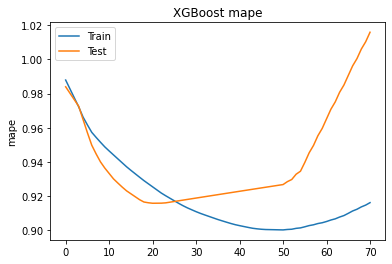

In [46]:
results = reg.evals_result()
epochs = len(results['validation_0']['mape'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mape'], label='Train')
ax.plot(x_axis, results['validation_1']['mape'], label='Test')
ax.legend()
plt.ylabel('mape')
plt.title('XGBoost mape')
plt.show()

In [47]:
reg.best_iteration

20

In [48]:
reg.best_score

0.915922146756202

In [49]:
pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['Importancia']).sort_values(by='Importancia',ascending=False)

,Importancia
Day,0.404597
Month,0.333611
Day_of_year,0.157055
produto_valor_unitario_comercializacao,0.079086
Day_of_week,0.025651


# Prevendo o Futuro!

In [50]:
db5.index.max()

Timestamp('2021-09-30 00:00:00')

In [51]:
future = pd.date_range('2021-09-30','2022-09-30',freq='3M')
future_df = pd.DataFrame(data=future,columns=['nota_data_emissao'])

In [52]:
future_df['produto_valor_unitario_comercializacao'] = 0
future_df['Year'] = future_df['nota_data_emissao'].dt.year
future_df['Month'] = future_df['nota_data_emissao'].dt.month
future_df['Day'] = future_df['nota_data_emissao'].dt.day
future_df['Day_of_week'] = future_df['nota_data_emissao'].dt.day_of_week
future_df['Day_of_year'] = future_df['nota_data_emissao'].dt.day_of_year


In [53]:
future_df.set_index('nota_data_emissao',inplace=True)

In [54]:
# Vamos atribuir valores arbitrarios para a variavel "produto_valor_unitario_comercializacao", ja que, em boa medida depende da empresa de quanto colocar este preço, logo poderíase ter acesso
# a essa informação. Também da pra fazer a previsão sem esta variavel, mas como os valores mantem uma oscilação controlada, da pra utilizar a data historica para usar valores arbitrarios
# proximos aos valores promedios.

future_df['produto_valor_unitario_comercializacao'] = [32.02,30.47,32.02,29.94,32.47]

In [55]:
future_df['produto_quantidade'] = reg.predict(future_df[FEATURES])

In [56]:
future_df['produto_quantidade'] = future_df['produto_quantidade'].round(0)

In [57]:
# Provavelmente o valor do target "produto_quantidade" tenha saido o mesmo ja que por estarmos pegando periodos de 3 em 3 meses, que representariam os quartis Q1 Q2 Q3 e Q4 do ano, 
# algumas variaveis se repetem, por exemplo Day e Day_of_week.

future_df[1:] # Também podemos desconsiderar o primeiro valor ja que era puramente para referencia dos quartis.

,produto_valor_unitario_comercializacao,Year,Month,Day,Day_of_week,Day_of_year,produto_quantidade
nota_data_emissao,,,,,,,
2021-12-31,30.47,2021,12,31,4,365,22.0
2022-03-31,32.02,2022,3,31,3,90,10.0
2022-06-30,29.94,2022,6,30,3,181,22.0
2022-09-30,32.47,2022,9,30,4,273,22.0


#### Métricas
Os melhores valores encontrados para as metricas do modelo foram:

RMSE <br>
rmse = 662.7145726432304<br> Presenta um valor bastante elevado, pelo que provavelmente não consiga prever o resultado real <br>

MAPE<BR>
mape = 0.915922146756202 <br>Também presenta um valor muito elevado, o que pode gerar que a diferença entre o previsto e o resultado real possa diferir em um 91,59%

#### Importancia dos features

Também é bom mencionar, que dentro dos features o variaveis independentes, o día do mes, seguido do mes, foram as de maior relevancia, a pesar de que nenhuma se destacou significativamente

In [58]:
pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['Importancia']).sort_values(by='Importancia',ascending=False)

,Importancia
Day,0.404597
Month,0.333611
Day_of_year,0.157055
produto_valor_unitario_comercializacao,0.079086
Day_of_week,0.025651
